## Packages

In [30]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import norm
import statsmodels.formula.api as smf

## Data

In [12]:
# Generate data
x, y = datasets.make_regression(n_samples=100,
                                n_features=1,
                                noise=10)

In [168]:
# Create the dataframe
data = pd.DataFrame(list(zip(x.flatten(), y)),
               columns =['x', 'y'])
data

,x,y
0,0.083191,4.329408
1,1.778799,95.412219
2,0.093974,17.107475
3,-1.399399,-85.306632
4,-1.022714,-65.563403
...,...,...
95,-1.370349,-71.944154
96,-0.264199,-29.742349
97,-1.312012,-73.078023
98,0.531323,25.683228


## OLS

In [169]:
# OLS line
formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept     0.531490
x            58.109462
dtype: float64

In [170]:
# Get the residuals
results.resid.std()

9.428722899550861

In [171]:
# Get our equation of the OLS line
inter = results.params['Intercept']
slope = results.params['x']
x_vals = np.arange(min(x), max(x), 0.1)
ols_line = inter + slope * x_vals

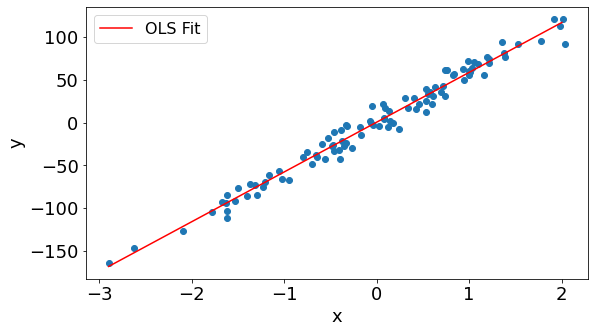

In [172]:
# Plot the target against our feature with the OLS regression
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(data['x'], data['y'])
ax.plot(xs, ols_line,label='OLS Fit', color='red')
ax.ticklabel_format(style='plain')
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.savefig('pic.png')
plt.show()

## Priors

In [173]:
def make_uninformative_prior(name,data):
    """Function to make priors."""
    df = pd.DataFrame({name:data})
    df['Prior'] = 1/len(data)
    return df

In [177]:
# Create a range of values for the slope
data_slope = np.linspace(results.params['x']*0.8,
                         results.params['x']*1.2, num=60)
prior_slope = make_uninformative_prior('slope',data_slope)
prior_slope.head()

,slope,Prior
0,46.487569,0.016667
1,46.881532,0.016667
2,47.275494,0.016667
3,47.669457,0.016667
4,48.063419,0.016667


In [174]:
# Create a range of values for the intercept
data_inter = np.linspace(results.params['Intercept']*0.8,
                         results.params['Intercept']*1.2, num=60)
prior_inter = make_uninformative_prior('intercept',data_inter)
prior_inter.head()

,intercept,Prior
0,0.425192,0.016667
1,0.428795,0.016667
2,0.432399,0.016667
3,0.436002,0.016667
4,0.439605,0.016667


In [176]:
# Create a range of values for the sigma
data_sigma = np.linspace(results.resid.std()*0.8,
                         results.resid.std()*1.2, num=60)
prior_sigma = make_uninformative_prior('sigma',data_sigma)
prior_sigma.head()

,sigma,Prior
0,7.542978,0.016667
1,7.606902,0.016667
2,7.670825,0.016667
3,7.734749,0.016667
4,7.798672,0.016667


## Likelihood

In [192]:
# Counter for the row index
counter = 0

# Dataframe to store the combinations in
df = pd.DataFrame(columns=['slope','intercept','sigma','prior'])

# Iterate through the slope
for slope in prior_slope['slope']:
    prob_slope = \
    prior_slope['Prior'].loc[prior_slope['slope'] == slope]
    
    # Iterate through the intercept
    for intercept in prior_inter['intercept']:
        prob_inter = \
        prior_inter['Prior'].loc[prior_inter['intercept'] \
                                 == intercept]
        
        # Iterate through the error
        for sigma in prior_sigma['sigma']:
            prob_sigma = \
            prior_sigma['Prior'].loc[prior_sigma['sigma'] == sigma]
            
            # Calculate the prior of this specific combination
            prob = \
            float(prob_slope)*float(prob_inter)*float(prob_sigma)
            
            # Insert the row of data
            df.loc[counter] = \
            [slope] + [intercept] + [sigma] + [prob]
            
            # Update row index
            counter += 1

In [195]:
# View our df
df

,slope,intercept,sigma,prior
0,46.487569,0.425192,7.542978,0.000005
1,46.487569,0.425192,7.606902,0.000005
2,46.487569,0.425192,7.670825,0.000005
3,46.487569,0.425192,7.734749,0.000005
4,46.487569,0.425192,7.798672,0.000005
...,...,...,...,...
215995,69.731354,0.637788,11.058773,0.000005
215996,69.731354,0.637788,11.122697,0.000005
215997,69.731354,0.637788,11.186620,0.000005
215998,69.731354,0.637788,11.250544,0.000005


In [196]:
counter = 0
df['likelihood'] = df['prior']

# Loop over the combination of values
for slope in prior_slope['slope']:
    for intercept in prior_inter['intercept']:        
        for sigma in prior_sigma['sigma']:
            
            # Compute the predictions from this line
            predictions = slope * data['x'] + intercept
            
            # Compute residual/errors of this line
            residuals = data['y'] - predictions
            
            # Compute the likelihood function
            likelihoods = norm(0, sigma).pdf(residuals)
            
            # Compute the total likelihood
            df['likelihood'].loc[counter] = likelihoods.prod()
            counter += 1

In [197]:
# View data
df

,slope,intercept,sigma,prior,likelihood
0,46.487569,0.425192,7.542978,0.000005,7.781344e-219
1,46.487569,0.425192,7.606902,0.000005,1.092113e-217
2,46.487569,0.425192,7.670825,0.000005,1.415345e-216
3,46.487569,0.425192,7.734749,0.000005,1.698358e-215
4,46.487569,0.425192,7.798672,0.000005,1.891944e-214
...,...,...,...,...,...
215995,69.731354,0.637788,11.058773,0.000005,4.384065e-187
215996,69.731354,0.637788,11.122697,0.000005,7.478815e-187
215997,69.731354,0.637788,11.186620,0.000005,1.255970e-186
215998,69.731354,0.637788,11.250544,0.000005,2.077241e-186


## Update

In [198]:
# Computing and normalising the posterior
df['posterior'] = df['prior'] * df['likelihood']
df['posterior'] = df['posterior']/df['posterior'].sum()
df

,slope,intercept,sigma,prior,likelihood,posterior
0,46.487569,0.425192,7.542978,0.000005,7.781344e-219,6.162104e-64
1,46.487569,0.425192,7.606902,0.000005,1.092113e-217,8.648523e-63
2,46.487569,0.425192,7.670825,0.000005,1.415345e-216,1.120823e-61
3,46.487569,0.425192,7.734749,0.000005,1.698358e-215,1.344943e-60
4,46.487569,0.425192,7.798672,0.000005,1.891944e-214,1.498245e-59
...,...,...,...,...,...,...
215995,69.731354,0.637788,11.058773,0.000005,4.384065e-187,3.471774e-32
215996,69.731354,0.637788,11.122697,0.000005,7.478815e-187,5.922530e-32
215997,69.731354,0.637788,11.186620,0.000005,1.255970e-186,9.946120e-32
215998,69.731354,0.637788,11.250544,0.000005,2.077241e-186,1.644982e-31


## Posterior

In [199]:
# Get the marginal probability
slope_df = df.groupby('slope').sum()

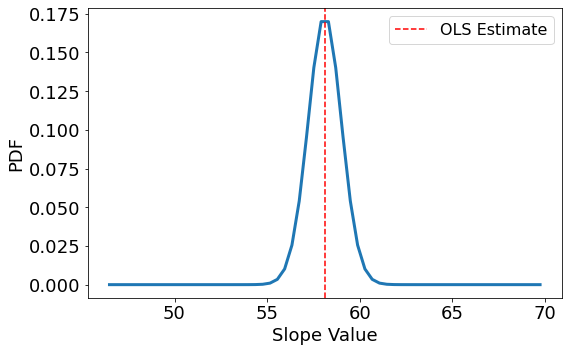

In [200]:
# Plot the posterior distribution of the slope
plt.figure(figsize=(8,5))
plt.plot(slope_df.index, slope_df.posterior, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Slope Value', fontsize=18)
plt.ylabel('PDF', fontsize=18)
plt.axvline(results.params['x'], color='red', ls='--', label='OLS Estimate')
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('c.png')
plt.show()

In [201]:
# Get the marginal probability
intercept_df = df.groupby('intercept').sum()

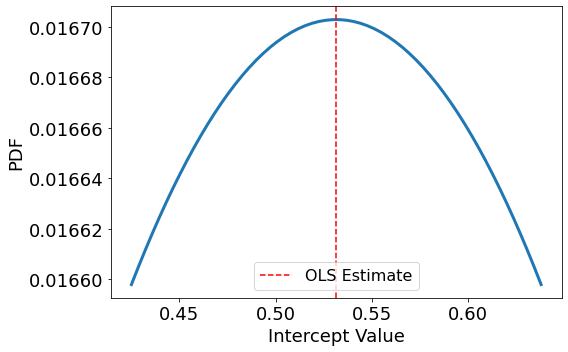

In [202]:
# Plot the posterior distribution of the slope
plt.figure(figsize=(8,5))
plt.plot(intercept_df.index, intercept_df.posterior, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Intercept Value', fontsize=18)
plt.ylabel('PDF', fontsize=18)
plt.axvline(results.params['Intercept'], color='red', ls='--', label='OLS Estimate')
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('c.png')
plt.show()

In [203]:
# Get the marginal probability
sigma_df = df.groupby('sigma').sum()

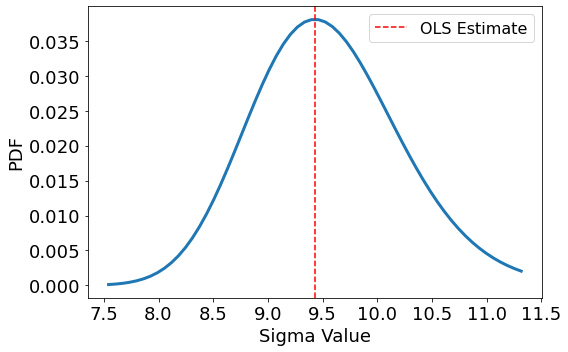

In [204]:
# Plot the posterior distribution of the slope
plt.figure(figsize=(8,5))
plt.plot(sigma_df.index, sigma_df.posterior, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Sigma Value', fontsize=18)
plt.ylabel('PDF', fontsize=18)
plt.axvline(results.resid.std(), color='red', ls='--', label='OLS Estimate')
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('d.png')
plt.show()